# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what you could sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import time
import json
import requests
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline

# Data extraction and cleaning

## Extract data from sqlite database

In [2]:
# Create connection and cursor
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [3]:
# View tables
cur.execute("""
SELECT name
FROM sqlite_master
WHERE type = 'table';""").fetchall()

[('sqlite_sequence',),
 ('Matches',),
 ('Teams_in_Matches',),
 ('Teams',),
 ('Unique_Teams',)]

In [4]:
# Get data for 2011
cur.execute("""
SELECT *
FROM Matches
WHERE Season = 2011;""")
matches_2011 = pd.DataFrame(cur.fetchall())
matches_2011.columns = [x[0] for x in cur.description]
matches_2011.head(20)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H
6,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D
7,1099,D1,2011,2012-04-21,Werder Bremen,Bayern Munich,1,2,A
8,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,A
9,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H


## Get dates for use with API

In [5]:
# Select only unique dates
dates_unique = matches_2011['Date'].unique()
print(len(dates_unique))

# Select 5 dates for testing API calls
five_unique_dates = dates_unique[:5]
print(f'Sample dates for class development: {five_unique_dates}')

165
Sample dates for class development: ['2012-03-31' '2011-12-11' '2011-08-13' '2011-11-27' '2012-02-18']


# Create and test classes

## GetBerlinWeather()

In [6]:
# Create a class to generate a dictionary of game dates with boolean values 
# to indicate whether it rained in Berlin that day at noon
class GetBerlinWeather():
    """Create a dictionary of boolean values for rain in Berlin on select dates
       Dependencies: json, requests, time"""
    
    # Instantiate with default elements for request URLs
    def __init__(self):
        self.lat = '52.5065133'
        self.long = '13.1445545'
        self.url_stem = 'https://api.darksky.net/forecast/'
        self.api_key_path = '/Users/jennykreiger/.secret/darksky_api.json'

    # Find API key on local machine
    def locate_api_key(self):
        with open(self.api_key_path) as f:
            return json.load(f)
    
    # Import API key without displaying it
    def extract_api_key(self):
        keys = self.locate_api_key()
        self.key = keys['api_key']
        return self.key
    
    # Create an empty dictionary to contain weather data
    def initialize_weather_dict(self, unique_dates_list):
        weather_dict = {}
        for date in unique_dates_list:
            weather_dict[date] = False
        return weather_dict
    
    # Concatenate request URLs for selected dates
    def concat_request_urls(self, unique_dates_list):
        key = str(self.extract_api_key())
        datetime = [x+'T12:00:00' for x in unique_dates_list]
        urls_list = []
        for date in datetime:
            request_url = self.url_stem + key + '/' + self.lat + ',' + self.long + ',' + date
            urls_list.append(request_url)
        return urls_list

    # Populate a weather_dict for selected dates
    def fill_weather_dict(self, unique_dates_list):
        urls = self.concat_request_urls(unique_dates_list)
        weather_dict = self.initialize_weather_dict(unique_dates_list)
        for date, url in list(zip(unique_dates_list, urls)):
            response = requests.get(url)
            if response.status_code != requests.codes.ok:
                print(f'The request for {url} has failed.')
            data = response.json()
            icon = data['daily']['data'][0]['icon']
            if icon == 'rain':
                weather_dict[date] = True
            time.sleep(0.2)
        return weather_dict
            

In [7]:
# Create a test instance
gbw = GetBerlinWeather()

In [8]:
# View dictionary generated by test instance
gbw.fill_weather_dict(five_unique_dates)

{'2012-03-31': True,
 '2011-12-11': False,
 '2011-08-13': False,
 '2011-11-27': False,
 '2012-02-18': False}

## MongoHandler()

In [9]:
class MongoHandler():
    """Creates a MongoDB instance with methods to prep and insert records.
       Be sure to open a connection to MongoDB before instantiating an object
       of this class."""
    
    # Instantiate the database
    def __init__(self):
        self.client = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
        self.db = self.client['section16_lab_db']
        self.collection = self.db['section16_lab_collection']
    
    # Structure input data for insertion into the database
    def prep_record(self, name, goals, wins, histogram, rain_win_rate):
        data = {'team_name': name,
               'total_goals': goals,
               'total_wins': wins,
               'win_loss_histogram': histogram,
               'rain_game_win_rate': rain_win_rate}
        return data
    
    # Insert a prepped record into the database
    def insert_record(self, record):
        return self.collection.insert_one(record)

# Prep histogram function

In [10]:
# Define a function to create histogram representing wins and losses
def hist_it(team, show=False):
    
    # Convert win/loss counts into a list of 'Win' and 'Loss/Draw'
    data_for_hist = []

    for n in range(team['wins']):
        data_for_hist.append('Win')
    for n in range(team['losses']):
        data_for_hist.append('Loss/Draw')
    histogram = plt.hist(data_for_hist)
    
    # For testing purposes, set show=True
    if show:     
        print(team['wins'], ' wins')
        print(team['losses'], ' losses/draws')
        plt.show()
    
    return histogram
    

In [11]:
# Test the function on a single team
hist_it(team_dicts['Bayern Munich'], show=True)

NameError: name 'team_dicts' is not defined

# Make the joined-up dataset 

Add a column to the main dataset to convey (True/False) whether it was raining in Berlin on the match date

In [12]:
# Instantiate a GetBerlinWeather() object
weather_data = GetBerlinWeather()

In [13]:
# Get weather data from API into a dictionary
weather_dict = weather_data.fill_weather_dict(dates_unique)
weather_dict

{'2012-03-31': True,
 '2011-12-11': False,
 '2011-08-13': False,
 '2011-11-27': False,
 '2012-02-18': False,
 '2012-01-20': True,
 '2012-02-04': False,
 '2012-04-21': False,
 '2011-09-18': True,
 '2011-10-23': True,
 '2011-10-01': False,
 '2012-03-03': False,
 '2011-08-27': True,
 '2012-03-17': False,
 '2011-11-06': True,
 '2012-05-05': True,
 '2012-04-11': False,
 '2011-12-17': True,
 '2012-02-03': False,
 '2011-10-29': False,
 '2012-01-22': True,
 '2011-12-03': True,
 '2012-04-14': False,
 '2012-03-25': False,
 '2012-03-10': False,
 '2012-04-07': False,
 '2011-11-19': False,
 '2011-10-14': False,
 '2011-09-24': False,
 '2012-04-28': False,
 '2011-12-18': True,
 '2012-03-02': False,
 '2012-03-16': False,
 '2012-02-17': True,
 '2011-08-06': True,
 '2011-11-04': False,
 '2011-09-16': False,
 '2011-07-15': False,
 '2012-05-06': True,
 '2012-02-11': False,
 '2011-10-02': False,
 '2012-03-30': False,
 '2011-10-22': False,
 '2011-08-26': True,
 '2011-08-07': True,
 '2012-02-24': True,
 '201

In [14]:
# Use weather_dict to populate a new column in matches_2011
rain_values = []
for date in matches_2011['Date']:
    rain_values.append(weather_dict[date])

matches_2011['rain'] = rain_values
matches_2011.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,rain
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,True
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,False
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,False
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,False
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,False


# Make a dictionary for each team, update with data from DataFrame

In [15]:
# Get a list of unique team names
teams_list = matches_2011['HomeTeam'].unique()
len(teams_list)

56

In [16]:
# Create a dict of dicts and initialize all keys to 0
team_dicts = {}

for team in teams_list:
    data = {'matches': 0,
            'goals': 0,
            'wins': 0,
            'losses': 0,
            'rain_wins': 0,
            'rain_losses': 0}
    team_dicts[team] = data

In [17]:
# Define a function to determine the outcome of each match
def update_team_dict(row):
    
    # Assign variables using row data
    home = row['HomeTeam']
    away = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    home_won = False
    away_won = False
    rain = row['rain']
    
    # Determine match outcome
    if row['FTR'] == 'H':
        home_won = True
        away_won = False
    elif row['FTR'] == 'A':
        home_won = False
        away_won = True
    else:
        home_won = False
        away_won = False
    
    # Update team dictionaries
    update_scorecard(home, home_goals, home_won, rain)    
    update_scorecard(away, away_goals, away_won, rain)
    
# Define a function to update team dictionaries with data from matches_2011
def update_scorecard(team, goals, won, rain):
    team = team_dicts[team]
    team['matches'] += 1
    team['goals'] += goals
    if won == True:
        team['wins'] += 1
        if rain == True:
            team['rain_wins'] += 1
    else:
        team['losses'] += 1
        team['rain_losses'] += 1   

In [18]:
# Apply the functions row-wise to matches_2011
matches_2011.apply(update_team_dict, axis=1)

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
962    None
963    None
964    None
965    None
966    None
967    None
968    None
969    None
970    None
971    None
972    None
973    None
974    None
975    None
976    None
977    None
978    None
979    None
980    None
981    None
982    None
983    None
984    None
985    None
986    None
987    None
988    None
989    None
990    None
991    None
Length: 992, dtype: object

In [19]:
# View the populated dict of dicts
print(team_dicts)

{'Nurnberg': {'matches': 34, 'goals': 38, 'wins': 12, 'losses': 22, 'rain_wins': 5, 'rain_losses': 22}, 'Stuttgart': {'matches': 34, 'goals': 63, 'wins': 15, 'losses': 19, 'rain_wins': 3, 'rain_losses': 19}, 'Wolfsburg': {'matches': 34, 'goals': 47, 'wins': 13, 'losses': 21, 'rain_wins': 4, 'rain_losses': 21}, 'Mainz': {'matches': 34, 'goals': 47, 'wins': 9, 'losses': 25, 'rain_wins': 2, 'rain_losses': 25}, 'Freiburg': {'matches': 34, 'goals': 45, 'wins': 10, 'losses': 24, 'rain_wins': 3, 'rain_losses': 24}, "M'gladbach": {'matches': 34, 'goals': 49, 'wins': 17, 'losses': 17, 'rain_wins': 8, 'rain_losses': 17}, 'Hamburg': {'matches': 34, 'goals': 35, 'wins': 8, 'losses': 26, 'rain_wins': 2, 'rain_losses': 26}, 'Werder Bremen': {'matches': 34, 'goals': 49, 'wins': 11, 'losses': 23, 'rain_wins': 5, 'rain_losses': 23}, 'Schalke 04': {'matches': 34, 'goals': 74, 'wins': 20, 'losses': 14, 'rain_wins': 5, 'rain_losses': 14}, 'Hannover': {'matches': 34, 'goals': 41, 'wins': 12, 'losses': 22, 

# Create and populate Mongo database

In [20]:
# Instantiate a MongoHandler() object
database = MongoHandler()

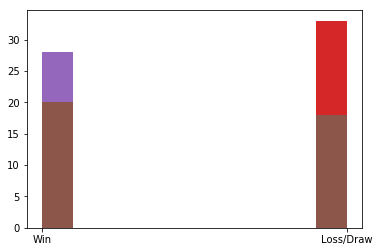

In [21]:
# Populate the database with a record for each team
for name, data in team_dicts.items():
    
    # Calculate rain day win rate
    if data['rain_wins'] == 0 and data['rain_losses'] == 0:
        rain_win_rate = 'n/a'
    else:
        rain_games = data['rain_wins'] + data['rain_losses']
        rain_win_rate = round((data['rain_wins'] / rain_games), 2)
    
    # Generate histogram
    # NB: histogram object gets coerced to string to make it easier to insert
    # in the database
    hist = str(hist_it(data))
    
    # Prep team record with relevant data
    record = database.prep_record(name=name, goals=data['goals'], 
                                  wins=data['wins'], histogram=hist,
                                  rain_win_rate=rain_win_rate)
    
    # Print record for inspection
    # print(record)
    
    # Insert record into database
    database.insert_record(record)
    
    # Delete the histogram to avoid overplotting
    del(hist)

# Inspect the database

In [28]:
# Inspect the database
coll = database.collection
query = coll.find({'team_name': 'Aachen'})
for i in query:
    print(i)

{'_id': ObjectId('5d81589c937fb6aa58ee5567'), 'team_name': 'Aachen', 'total_goals': 30, 'total_wins': 6, 'rain_game_win_rate': 0.1}
{'_id': ObjectId('5d8158e0937fb6aa58ee55a1'), 'team_name': 'Aachen', 'total_goals': 30, 'total_wins': 6, 'win_loss_histogram': '(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 10 Patch objects>)', 'rain_game_win_rate': 0.1}
{'_id': ObjectId('5d815918937fb6aa58ee55d9'), 'team_name': 'Aachen', 'total_goals': 30, 'total_wins': 6, 'win_loss_histogram': '(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 10 Patch objects>)', 'rain_game_win_rate': 0.1}
{'_id': ObjectId('5d816023113a382578f962dc'), 'team_name': 'Aachen', 'total_goals': 30, 'total_wins': 6, 'win_loss_histogram': '(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1

There are four duplicate entries for Aachen, which makes me think that the database has been populated with identical data four times (as I was rerunning the code).

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!